# SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

from cvxopt import matrix, solvers

## Generate and visualize the data

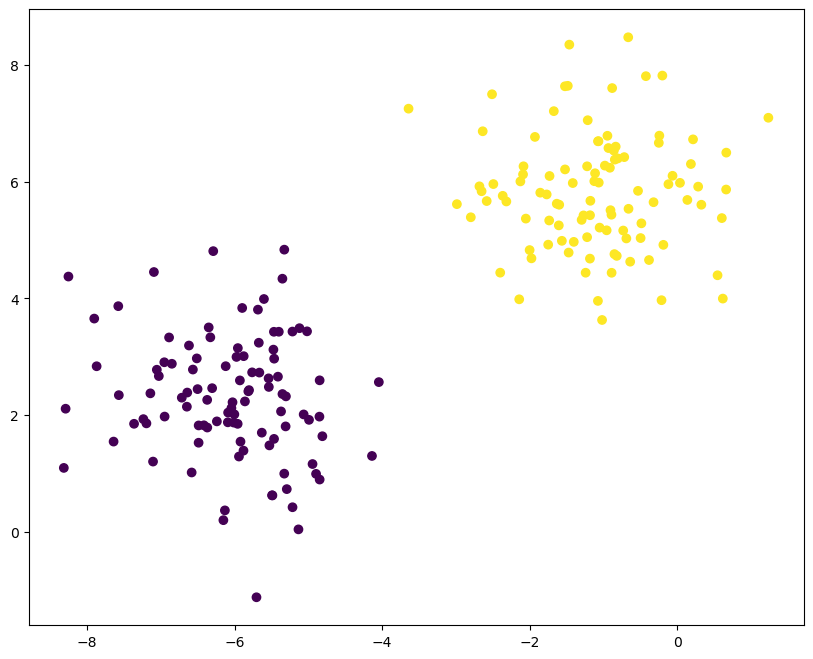

In [2]:
N = 200  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 1234  # for reproducible experiments

alpha_tol = 1e-4 # threshold for choosing support vectors

X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed)
y[y == 0] = -1  # it is more convenient to have {-1, 1} as class labels (instead of {0, 1})
y = y.astype(np.float64)
plt.figure(figsize=[10, 8])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Solving the SVM dual problem

The SVM dual problem can be formulated as a Quadratic programming (QP) problem.
We will solve it using a QP solver from the `CVXOPT` library.

We use the following form of a QP problem:
$$
\text{minimize}_{\mathbf{x}}\quad
    \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} \\
\text{subject to}\quad
    \mathbf{G}\mathbf{x} \le \mathbf{h}\text{ and }
    \mathbf{A}\mathbf{x} = \mathbf{b}\, .
$$

In [3]:
def solve_dual_svm(X, y):
    """Solve the dual formulation of the SVM problem.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    alphas : array, shape [N]
        Solution of the dual problem.
    """
    # These variables have to be of type cvxopt.matrix
    # P = matrix(np.einsum("i, j, ik, jk -> ij", y, y, X, X))
    Z = y[:, None] * X
    P = matrix(Z.dot(Z.T))
    q = matrix(-np.ones([N, 1]))
    G = matrix(-np.eye(N))
    h = matrix(np.zeros(N))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    return alphas.reshape(-1)

## Recovering the weights and the bias

In [4]:
def compute_weights_and_bias(alpha, X, y):
    """Recover the weights w and the bias b using the dual solution alpha.
    
    Parameters
    ----------
    alpha : array, shape [N]
        Solution of the dual problem.
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    
    Returns
    -------
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    w = np.dot(X.T, alpha * y)
    support_vectors = (alpha > alpha_tol)
    biases = y[support_vectors] - np.dot(X[support_vectors, :], w)
    # b = np.mean(biases)
    # more numerically stable solution, see Bishop (Eq.7.18)
    b = np.sum(alpha[support_vectors] * biases) / np.sum(alpha[support_vectors])
    return w, b

## Visualize the result

In [5]:
def plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b):
    """Plot the data as a scatter plot together with the separating hyperplane.
    
    Parameters
    ----------
    X : array, shape [N, D]
        Input features.
    y : array, shape [N]
        Binary class labels (in {-1, 1} format).
    alpha : array, shape [N]
        Solution of the dual problem.
    w : array, shape [D]
        Weight vector.
    b : float
        Bias term.
    """
    plt.figure(figsize=[10, 8])
    # Plot the hyperplane
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.linspace(X[:, 0].min(), X[:, 0].max())
    plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
    plt.plot(x, x * slope + intercept - 1/w[1], 'k--')
    plt.plot(x, x * slope + intercept + 1/w[1], 'k--')
    # Plot all the datapoints
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # Mark the support vectors
    support_vecs = (alpha > alpha_tol)
    plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')

The reference solution is

    w = array([0.73935606 0.41780426])
    
    b = 0.919937145

Indices of the support vectors are
    
    [ 78 134 158]

In [6]:
alpha = solve_dual_svm(X, y)
w, b = compute_weights_and_bias(alpha, X, y)
print("w =", w)
print("b =", b)
print("support vectors:", np.arange(len(alpha))[alpha > alpha_tol])

w = [0.73935606 0.41780426]
b = 0.919937134414446
support vectors: [ 78 134 158]


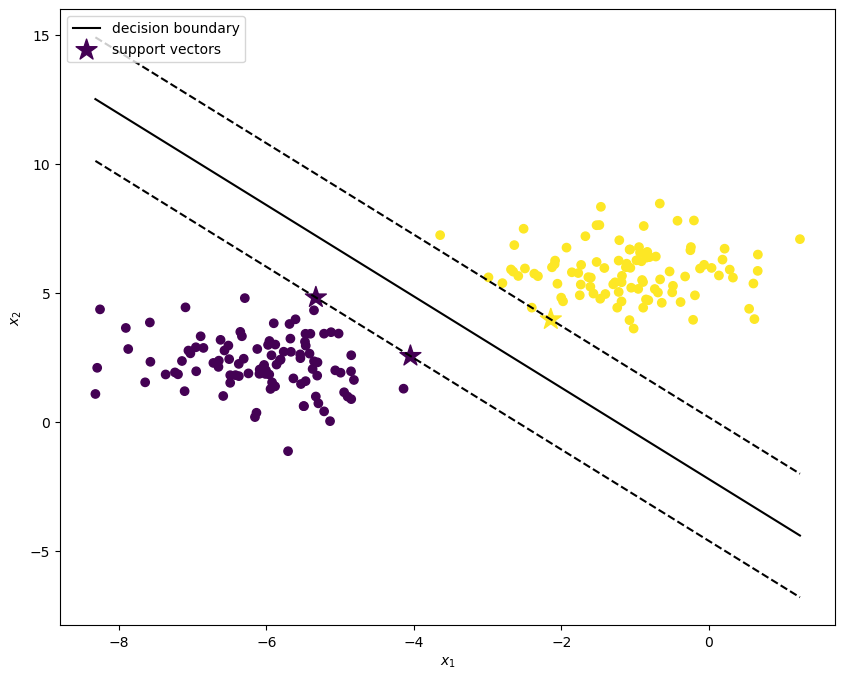

In [7]:
plot_data_with_hyperplane_and_support_vectors(X, y, alpha, w, b)
plt.show()